In [ ]:
%matplotlib inline
import math
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
from sklearn.ensemble import RandomForestClassifier

!pip install scikit-plot
import scikitplot as skplt
!pip install dmba
from dmba import plotDecisionTree, regressionSummary, classificationSummary, liftChart, gainsChart, adjusted_r2_score, exhaustive_search, backward_elimination, forward_selection, AIC_score, BIC_score

# Not removing missing values

In [ ]:
KSI = pd.read_csv('KSI.csv')

In [ ]:
KSI_d = KSI.loc[:,['ACCLASS','INVTYPE','DRIVACT']]
KSI_d

,ACCLASS,INVTYPE,DRIVACT
0,Fatal,Driver,Failed to Yield Right of Way
1,Fatal,Pedestrian,<Null>
2,Fatal,Motorcycle Driver,Disobeyed Traffic Control
3,Fatal,Driver,Driving Properly
4,Fatal,Driver,Other
...,...,...,...
16855,Non-Fatal Injury,Cyclist,<Null>
16856,Non-Fatal Injury,Driver,Failed to Yield Right of Way
16857,Non-Fatal Injury,Driver,Driving Properly
16858,Non-Fatal Injury,Passenger,<Null>


In [ ]:
objdtype_cols = KSI_d.select_dtypes(["object"]).columns
KSI_d[objdtype_cols] = KSI_d[objdtype_cols].astype('category')

In [ ]:
driver = KSI_d[KSI_d['INVTYPE'].str.contains('Driver')]
driver

,ACCLASS,INVTYPE,DRIVACT
0,Fatal,Driver,Failed to Yield Right of Way
2,Fatal,Motorcycle Driver,Disobeyed Traffic Control
3,Fatal,Driver,Driving Properly
4,Fatal,Driver,Other
7,Non-Fatal Injury,Driver,Failed to Yield Right of Way
...,...,...,...
16853,Non-Fatal Injury,Motorcycle Driver,Driving Properly
16854,Non-Fatal Injury,Driver,Improper Passing
16856,Non-Fatal Injury,Driver,Failed to Yield Right of Way
16857,Non-Fatal Injury,Driver,Driving Properly


In [ ]:
driver['ACCLASS'] = np.where(driver['ACCLASS'].str.contains('Non-Fatal'), 0, 1)
driver

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ACCLASS,INVTYPE,DRIVACT
0,1,Driver,Failed to Yield Right of Way
2,1,Motorcycle Driver,Disobeyed Traffic Control
3,1,Driver,Driving Properly
4,1,Driver,Other
7,0,Driver,Failed to Yield Right of Way
...,...,...,...
16853,0,Motorcycle Driver,Driving Properly
16854,0,Driver,Improper Passing
16856,0,Driver,Failed to Yield Right of Way
16857,0,Driver,Driving Properly


In [ ]:
X = pd.get_dummies(driver.drop(columns=['ACCLASS','INVTYPE']))
y = driver['ACCLASS']

In [ ]:
X

,DRIVACT_<Null>,DRIVACT_Disobeyed Traffic Control,DRIVACT_Driving Properly,DRIVACT_Exceeding Speed Limit,DRIVACT_Failed to Yield Right of Way,DRIVACT_Following too Close,DRIVACT_Improper Lane Change,DRIVACT_Improper Passing,DRIVACT_Improper Turn,DRIVACT_Lost control,DRIVACT_Other,DRIVACT_Speed too Fast For Condition,DRIVACT_Speed too Slow,DRIVACT_Wrong Way on One Way Road
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16853,0,0,1,0,0,0,0,0,0,0,0,0,0,0
16854,0,0,0,0,0,0,0,1,0,0,0,0,0,0
16856,0,0,0,0,1,0,0,0,0,0,0,0,0,0
16857,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(X,y, test_size=0.4, random_state=1)

In [ ]:
fullClassTree = DecisionTreeClassifier(random_state=1)
fullClassTree.fit(train_X,train_y)

DecisionTreeClassifier(random_state=1)

In [ ]:
plotDecisionTree(fullClassTree,feature_names=train_X.columns)

InvocationException: ignored

In [ ]:
classificationSummary(valid_y,fullClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8762)

       Prediction
Actual    0    1
     0 3009    0
     1  425    0


#Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=1, n_estimators=500)
rf.fit(train_X, train_y)

RandomForestClassifier(n_estimators=500, random_state=1)

In [ ]:
importance = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

In [ ]:
df = pd.DataFrame({'feature': train_X.columns,
                   'importance': importance,
                   'std':std})
print(df.sort_values('importance', ascending=False))

                                 feature  importance       std
3          DRIVACT_Exceeding Speed Limit    0.411521  0.143139
5            DRIVACT_Following too Close    0.154381  0.065801
9                   DRIVACT_Lost control    0.129367  0.088843
8                  DRIVACT_Improper Turn    0.086467  0.060996
2               DRIVACT_Driving Properly    0.039035  0.052323
4   DRIVACT_Failed to Yield Right of Way    0.038966  0.043604
0                         DRIVACT_<Null>    0.028757  0.031084
7               DRIVACT_Improper Passing    0.023441  0.023471
10                         DRIVACT_Other    0.020273  0.027762
13     DRIVACT_Wrong Way on One Way Road    0.020068  0.032346
1      DRIVACT_Disobeyed Traffic Control    0.017388  0.033547
6           DRIVACT_Improper Lane Change    0.015985  0.022457
11  DRIVACT_Speed too Fast For Condition    0.014350  0.028331
12                DRIVACT_Speed too Slow    0.000000  0.000000


Text(0.5, 1.0, 'Visualizing Importance Features')

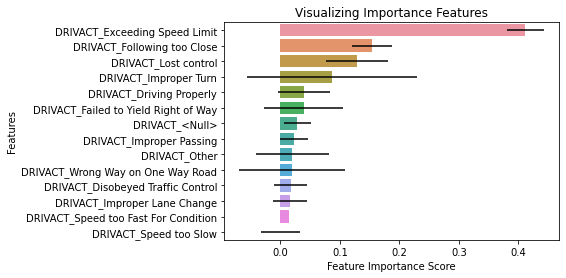

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
feature_imp=pd.Series(rf.feature_importances_,index=train_X.columns).sort_values(ascending=False)
std=np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
sns.barplot(x = feature_imp, y=feature_imp.index, xerr = std)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Importance Features')

In [ ]:
tf = pd.DataFrame({'feature': train_X.columns,'importance': rf.feature_importances_,'std':std})
tf = tf.sort_values('importance',ascending = False)
sns.barplot(x = tf['importance'], y=feature_imp.index, xerr = tf['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Importance Features')

In [ ]:
classificationSummary(valid_y, rf.predict(valid_X))

Confusion Matrix (Accuracy 0.8762)

       Prediction
Actual    0    1
     0 3009    0
     1  425    0


#Logistic Regression

In [ ]:
logit_reg = LogisticRegression(solver='liblinear', C=1e42, random_state=1)
logit_reg.fit(train_X, train_y)

LogisticRegression(C=1e+42, random_state=1, solver='liblinear')

In [ ]:
logit_reg.intercept_

array([-1.91760541])

In [ ]:
logit_reg.coef_

array([[-0.67780243, -0.04087087,  0.0500161 ,  1.16481123, -0.18048538,
        -2.00789341, -0.31083572, -0.70237564, -0.6111081 ,  0.40369166,
         0.11301077,  0.05540441,  0.        ,  0.82683197]])

In [ ]:
print(pd.DataFrame({'coef': logit_reg.coef_[0]}, index=X.columns))

                                          coef
DRIVACT_<Null>                       -0.677802
DRIVACT_Disobeyed Traffic Control    -0.040871
DRIVACT_Driving Properly              0.050016
DRIVACT_Exceeding Speed Limit         1.164811
DRIVACT_Failed to Yield Right of Way -0.180485
DRIVACT_Following too Close          -2.007893
DRIVACT_Improper Lane Change         -0.310836
DRIVACT_Improper Passing             -0.702376
DRIVACT_Improper Turn                -0.611108
DRIVACT_Lost control                  0.403692
DRIVACT_Other                         0.113011
DRIVACT_Speed too Fast For Condition  0.055404
DRIVACT_Speed too Slow                0.000000
DRIVACT_Wrong Way on One Way Road     0.826832


In [ ]:
logit_reg_prob = logit_reg.predict_proba(valid_X)
logit_reg_pred = logit_reg.predict(valid_X)

In [ ]:
logit_result = pd.DataFrame({'actual' : valid_y,
                             'p_0' : [p[0] for p in logit_reg_prob],
                             'p_1' : [p[1] for p in logit_reg_prob],
                             'predicted': logit_reg_pred})
logit_result

,actual,p_0,p_1,predicted
6798,0,0.876368,0.123632,0
6549,0,0.866179,0.133821,0
11766,0,0.876368,0.123632,0
14066,0,0.930565,0.069435,0
13096,0,0.866179,0.133821,0
...,...,...,...,...
10370,0,0.819641,0.180359,0
9824,0,0.876368,0.123632,0
3793,0,0.926130,0.073870,0
4604,0,0.819641,0.180359,0


In [ ]:
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.8762)

       Prediction
Actual    0    1
     0 3009    0
     1  425    0


#Remove Missing values

In [ ]:
KSI = pd.read_csv('KSI.csv')

In [ ]:
KSI_d = KSI.loc[:,['ACCLASS','INVTYPE','DRIVACT']]
KSI_d

,ACCLASS,INVTYPE,DRIVACT
0,Fatal,Driver,Failed to Yield Right of Way
1,Fatal,Pedestrian,<Null>
2,Fatal,Motorcycle Driver,Disobeyed Traffic Control
3,Fatal,Driver,Driving Properly
4,Fatal,Driver,Other
...,...,...,...
16855,Non-Fatal Injury,Cyclist,<Null>
16856,Non-Fatal Injury,Driver,Failed to Yield Right of Way
16857,Non-Fatal Injury,Driver,Driving Properly
16858,Non-Fatal Injury,Passenger,<Null>


In [ ]:
objdtype_cols = KSI_d.select_dtypes(["object"]).columns
KSI_d[objdtype_cols] = KSI_d[objdtype_cols].astype('category')

In [ ]:
driver = KSI_d[KSI_d['INVTYPE'].str.contains('Driver')]
driver

,ACCLASS,INVTYPE,DRIVACT
0,Fatal,Driver,Failed to Yield Right of Way
2,Fatal,Motorcycle Driver,Disobeyed Traffic Control
3,Fatal,Driver,Driving Properly
4,Fatal,Driver,Other
7,Non-Fatal Injury,Driver,Failed to Yield Right of Way
...,...,...,...
16853,Non-Fatal Injury,Motorcycle Driver,Driving Properly
16854,Non-Fatal Injury,Driver,Improper Passing
16856,Non-Fatal Injury,Driver,Failed to Yield Right of Way
16857,Non-Fatal Injury,Driver,Driving Properly


In [ ]:
driver['ACCLASS'] = np.where(driver['ACCLASS'].str.contains('Non-Fatal'), 0, 1)
driver

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ACCLASS,INVTYPE,DRIVACT
0,1,Driver,Failed to Yield Right of Way
2,1,Motorcycle Driver,Disobeyed Traffic Control
3,1,Driver,Driving Properly
4,1,Driver,Other
7,0,Driver,Failed to Yield Right of Way
...,...,...,...
16853,0,Motorcycle Driver,Driving Properly
16854,0,Driver,Improper Passing
16856,0,Driver,Failed to Yield Right of Way
16857,0,Driver,Driving Properly


In [ ]:
driver = driver[driver.DRIVACT != '<Null>']
driver

,ACCLASS,INVTYPE,DRIVACT
0,1,Driver,Failed to Yield Right of Way
2,1,Motorcycle Driver,Disobeyed Traffic Control
3,1,Driver,Driving Properly
4,1,Driver,Other
7,0,Driver,Failed to Yield Right of Way
...,...,...,...
16853,0,Motorcycle Driver,Driving Properly
16854,0,Driver,Improper Passing
16856,0,Driver,Failed to Yield Right of Way
16857,0,Driver,Driving Properly


In [ ]:
X = pd.get_dummies(driver['DRIVACT'])
y = driver['ACCLASS']

In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(X,y, test_size=0.4, random_state=1)

In [ ]:
fullClassTree = DecisionTreeClassifier(random_state=1)
fullClassTree.fit(train_X,train_y)

DecisionTreeClassifier(random_state=1)

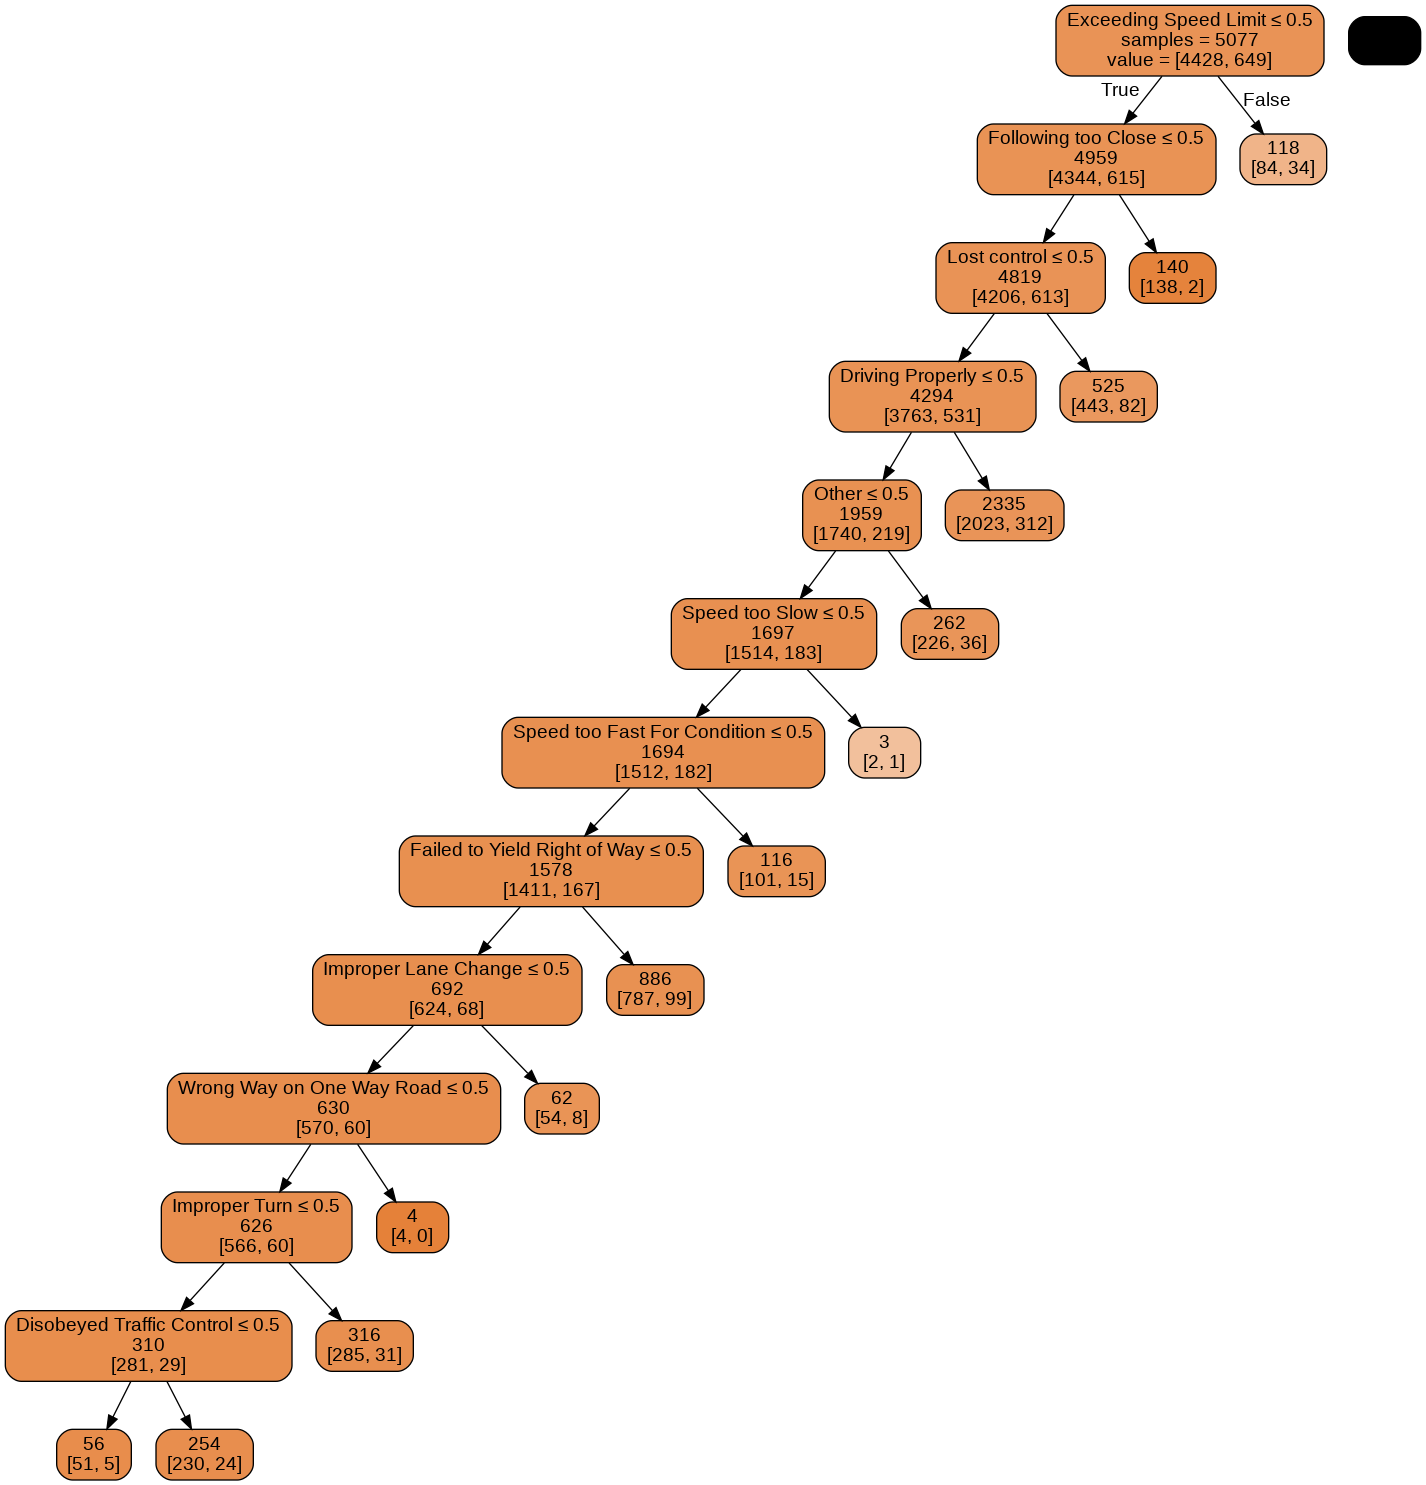

In [ ]:
plotDecisionTree(fullClassTree,feature_names=train_X.columns)

In [ ]:
classificationSummary(valid_y,fullClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8715)

       Prediction
Actual    0    1
     0 2950    0
     1  435    0


#Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=1, n_estimators=500)
rf.fit(train_X, train_y)

RandomForestClassifier(n_estimators=500, random_state=1)

In [ ]:
importance = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

In [ ]:
df = pd.DataFrame({'feature': train_X.columns,
                   'importance': importance,
                   'std':std})
print(df.sort_values('importance', ascending=False))

                         feature  importance       std
2          Exceeding Speed Limit    0.382261  0.146614
4            Following too Close    0.229544  0.085273
8                   Lost control    0.075515  0.070634
0      Disobeyed Traffic Control    0.048008  0.045735
7                  Improper Turn    0.047153  0.049667
3   Failed to Yield Right of Way    0.044869  0.051088
1               Driving Properly    0.043828  0.058232
11                Speed too Slow    0.040141  0.056402
9                          Other    0.023619  0.033417
6               Improper Passing    0.021234  0.026381
10  Speed too Fast For Condition    0.018291  0.026777
5           Improper Lane Change    0.017257  0.025366
12     Wrong Way on One Way Road    0.008279  0.005952


Text(0.5, 1.0, 'Visualizing Importance Features')

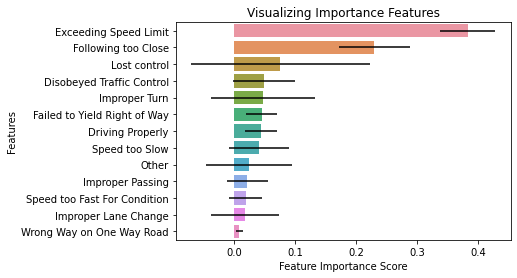

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
feature_imp=pd.Series(rf.feature_importances_,index=train_X.columns).sort_values(ascending=False)
std=np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
sns.barplot(x = feature_imp, y=feature_imp.index, xerr = std)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Importance Features')

Text(0.5, 1.0, 'Visualizing Importance Features')

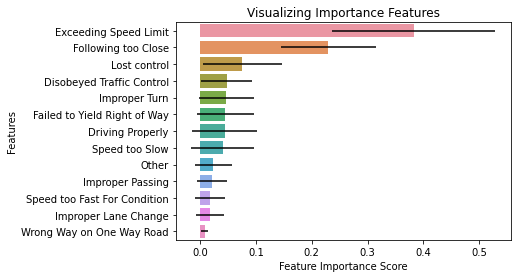

In [ ]:
tf = pd.DataFrame({'feature': train_X.columns,'importance': rf.feature_importances_,'std':std})
tf = tf.sort_values('importance',ascending = False)
sns.barplot(x = tf['importance'], y=feature_imp.index, xerr = tf['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Importance Features')

In [ ]:
classificationSummary(valid_y, rf.predict(valid_X))

Confusion Matrix (Accuracy 0.8715)

       Prediction
Actual    0    1
     0 2950    0
     1  435    0


#Logistic regression

In [ ]:
logit_reg = LogisticRegression(solver='liblinear', C=1e42, random_state=1)
logit_reg.fit(train_X, train_y)

LogisticRegression(C=1e+42, random_state=1, solver='liblinear')

In [ ]:
logit_reg.intercept_

array([-2.13413278])

In [ ]:
logit_reg.coef_

array([[-0.12588681,  0.26479273,  1.2296825 ,  0.06103643, -2.09996817,
         0.22459561, -0.18824988, -0.08436301,  0.44729155,  0.29712306,
         0.22706798,  1.44099044, -3.82824522]])

In [ ]:
print(pd.DataFrame({'coef': logit_reg.coef_[0]}, index=X.columns))

                                  coef
Disobeyed Traffic Control    -0.125887
Driving Properly              0.264793
Exceeding Speed Limit         1.229683
Failed to Yield Right of Way  0.061036
Following too Close          -2.099968
Improper Lane Change          0.224596
Improper Passing             -0.188250
Improper Turn                -0.084363
Lost control                  0.447292
Other                         0.297123
Speed too Fast For Condition  0.227068
Speed too Slow                1.440990
Wrong Way on One Way Road    -3.828245


In [ ]:
logit_reg_prob = logit_reg.predict_proba(valid_X)
logit_reg_pred = logit_reg.predict(valid_X)

In [ ]:
logit_result = pd.DataFrame({'actual' : valid_y,
                             'p_0' : [p[0] for p in logit_reg_prob],
                             'p_1' : [p[1] for p in logit_reg_prob],
                             'predicted': logit_reg_pred})
logit_result

,actual,p_0,p_1,predicted
6593,0,0.866382,0.133618,0
9781,0,0.866382,0.133618,0
3684,1,0.866382,0.133618,0
11545,0,0.866382,0.133618,0
15588,0,0.870689,0.129311,0
...,...,...,...,...
9378,0,0.866382,0.133618,0
191,0,0.866382,0.133618,0
12119,0,0.843808,0.156192,0
10517,0,0.888261,0.111739,0


In [ ]:
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.8715)

       Prediction
Actual    0    1
     0 2950    0
     1  435    0


#Visualization

In [ ]:
KSI = pd.read_csv('KSI.csv')

In [ ]:
KSI_d = KSI.loc[:,['ACCLASS','INVTYPE','DRIVACT']]
KSI_d

,ACCLASS,INVTYPE,DRIVACT
0,Fatal,Driver,Failed to Yield Right of Way
1,Fatal,Pedestrian,<Null>
2,Fatal,Motorcycle Driver,Disobeyed Traffic Control
3,Fatal,Driver,Driving Properly
4,Fatal,Driver,Other
...,...,...,...
16855,Non-Fatal Injury,Cyclist,<Null>
16856,Non-Fatal Injury,Driver,Failed to Yield Right of Way
16857,Non-Fatal Injury,Driver,Driving Properly
16858,Non-Fatal Injury,Passenger,<Null>


In [ ]:
driver = KSI_d[KSI_d['INVTYPE'].str.contains('Driver')]
driver

,ACCLASS,INVTYPE,DRIVACT
0,Fatal,Driver,Failed to Yield Right of Way
2,Fatal,Motorcycle Driver,Disobeyed Traffic Control
3,Fatal,Driver,Driving Properly
4,Fatal,Driver,Other
7,Non-Fatal Injury,Driver,Failed to Yield Right of Way
...,...,...,...
16853,Non-Fatal Injury,Motorcycle Driver,Driving Properly
16854,Non-Fatal Injury,Driver,Improper Passing
16856,Non-Fatal Injury,Driver,Failed to Yield Right of Way
16857,Non-Fatal Injury,Driver,Driving Properly


In [ ]:
driver[['ACCLASS','DRIVACT','INVTYPE']].groupby(['ACCLASS','DRIVACT']).agg(['count'])

INVTYPE
                                                    count
ACCLASS              DRIVACT                             
Fatal                <Null>                             8
                     Disobeyed Traffic Control         55
                     Driving Properly                 514
                     Exceeding Speed Limit             61
                     Failed to Yield Right of Way     153
                     Following too Close                4
                     Improper Lane Change              11
                     Improper Passing                   8
                     Improper Turn                     42
                     Lost control                     148
                     Other                             63
                     Speed too Fast For Condition      20
                     Speed too Slow                     2
                     Wrong Way on One Way Road          1
Non-Fatal Injury     <Null>                           115
                     Disobeyed Traffic Control        377
                     Driving Properly                3364
                     Exceeding Speed Limit            150
                     Failed to Yield Right of Way    1276
                     Following too Close              237
                     Improper Lane Change             103
                     Improper Passing                  87
                     Improper Turn                    479
                     Lost control                     726
                     Other                            402
                     Speed too Fast For Condition     167
                     Speed too Slow                     2
                     Wrong Way on One Way Road          8
Property Damage Only Driving Properly                   1
                     Speed too Fast For Condition       1

In [ ]:
driver.drop(columns = ['INVTYPE'])

,ACCLASS,DRIVACT
0,Fatal,Failed to Yield Right of Way
2,Fatal,Disobeyed Traffic Control
3,Fatal,Driving Properly
4,Fatal,Other
7,Non-Fatal Injury,Failed to Yield Right of Way
...,...,...
16853,Non-Fatal Injury,Driving Properly
16854,Non-Fatal Injury,Improper Passing
16856,Non-Fatal Injury,Failed to Yield Right of Way
16857,Non-Fatal Injury,Driving Properly


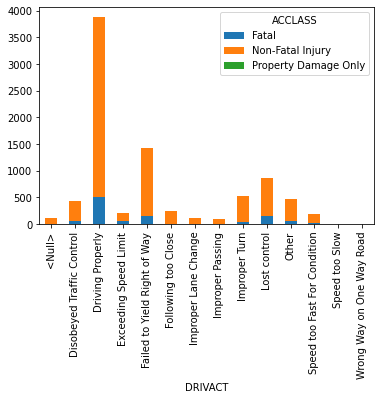

In [190]:
test = driver.groupby(['ACCLASS', 'DRIVACT'])['DRIVACT'].count().unstack('ACCLASS').fillna(0)
test.plot(kind='bar', stacked=True)